# Segmenting Customers with Python

## Import Data
Import our needed libraries and the Excel sheet to the dataframe **df**.

In [37]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [38]:
df = pd.read_excel('Online Retail.xlsx', sheet_name = 'Online Retail')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Cleanup
This is a very important step! We need to perform the following functions:
1. Remove cancelled orders (anything with a quantity of 0 or less)
2. Remove records with missing CustomerID
3. The dataset ends in a partial month so we need to exclude that month so that we are only handling complete months.

**Filtering to any quantities greater than 0**

In [39]:
df = df.loc[df['Quantity'] > 0]

**Removing missing CustomerID rows**

In [40]:
df = df[pd.notnull(df['CustomerID'])]

**Excluding ending month which is a partial month**

In [41]:
df = df.loc[df['InvoiceDate'] < '2011-12-01']

## Feature Engineering
We want to create some additional features that will be useful in our customer segmentation analysis.
1. Compute total sales
2. Aggregate and summarize our data by customer
3. Normalize our data for easier machine learning

**Computing total sales**

In [42]:
df['Sales'] = df['Quantity'] * df['UnitPrice']

**Aggregate and summarize by customer**

We want to determine the total sales amount, number of orders, and average order amounts.

In [43]:
customer_df = df.groupby('CustomerID').agg({
    'Sales': sum,
    'InvoiceNo': lambda x: x.nunique()
})
customer_df.columns = ['TotalSales','OrderCount']
customer_df.head()

,TotalSales,OrderCount
CustomerID,,
12346.0,77183.60,1
12347.0,4085.18,6
12348.0,1797.24,4
12349.0,1757.55,1
12350.0,334.40,1


In [44]:
customer_df['AvgOrderValue'] = customer_df['TotalSales']/customer_df['OrderCount']
customer_df.head(10)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12347.0,4085.18,6,680.863333
12348.0,1797.24,4,449.310000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000
12352.0,2506.04,8,313.255000
12353.0,89.00,1,89.000000
12354.0,1079.40,1,1079.400000
12355.0,459.40,1,459.400000


Clustering algorithms are affected by the scale of the data so now we move to normalize the data. We do this in two parts. First, the data is transformed into its rank. Then, we normalize the ranked data. Through normalizing the data, the data is centered on the mean and the mean is **0** with a standard deviation of **1**.

In [45]:
rank_df = customer_df.rank(method = 'first')
rank_df.head(10)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,4290.0,1.0,4298.0
12347.0,3958.0,3470.0,3888.0
12348.0,3350.0,2861.0,3303.0
12349.0,3321.0,2.0,4238.0
12350.0,1241.0,3.0,2561.0
12352.0,3630.0,3774.0,2360.0
12353.0,119.0,4.0,201.0
12354.0,2781.0,5.0,4151.0
12355.0,1670.0,6.0,3354.0


In [46]:
normalized_df = (rank_df - rank_df.mean()) / rank_df.std()
normalized_df.head(10)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,1.724999,-1.731446,1.731446
12347.0,1.457445,1.064173,1.401033
12348.0,0.967466,0.573388,0.929590
12349.0,0.944096,-1.730641,1.683093
12350.0,-0.732148,-1.729835,0.331622
12352.0,1.193114,1.309162,0.169639
12353.0,-1.636352,-1.729029,-1.570269
12354.0,0.508917,-1.728223,1.612981
12355.0,-0.386422,-1.727417,0.970690


## K-Means Clustering
The **k-means clustering** algorithm is a very frequently used algorithm for segmenting customers and understanding their behaviors. Running the algorithm only takes two lines of code: **(1)** importing the KMeans module from scikit-learn and **(2)** writing the one line of code to build the model.

In [47]:
from sklearn.cluster import KMeans

In [48]:
kmeans = KMeans(n_clusters = 4).fit(normalized_df[['TotalSales','OrderCount','AvgOrderValue']])

The above line of code splits the data into four segments based on the total sales, order counts, and average order value. Each cluster is given a label and a centered value which can be obtained below.

In [49]:
kmeans.labels_

array([0, 1, 1, ..., 2, 3, 1], dtype=int32)

In [50]:
kmeans.cluster_centers_

array([[-0.13271459, -0.85015948,  0.79867905],
       [ 1.20623695,  1.00587146,  0.86737214],
       [-1.24645935, -0.79772735, -1.06106555],
       [ 0.21677957,  0.71422443, -0.64277454]])

**Visualize the clustered data**

We begin by making a copy of the normalized dataframe and by adding in the cluster label for each CustomerID.

In [51]:
four_cluster_df = normalized_df[['TotalSales','OrderCount','AvgOrderValue']].copy(deep = True)
four_cluster_df['Cluster'] = kmeans.labels_
four_cluster_df.head(10)

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.724999,-1.731446,1.731446,0
12347.0,1.457445,1.064173,1.401033,1
12348.0,0.967466,0.573388,0.929590,1
12349.0,0.944096,-1.730641,1.683093,0
12350.0,-0.732148,-1.729835,0.331622,0
12352.0,1.193114,1.309162,0.169639,1
12353.0,-1.636352,-1.729029,-1.570269,2
12354.0,0.508917,-1.728223,1.612981,0
12355.0,-0.386422,-1.727417,0.970690,0


Now that each CustomerID has its cluster value (1-4), we can plot it. Given the three different columns (total sales, order count, and average order value), we can create a few different plots to compare these various columns. Each cluster will be given a different color.

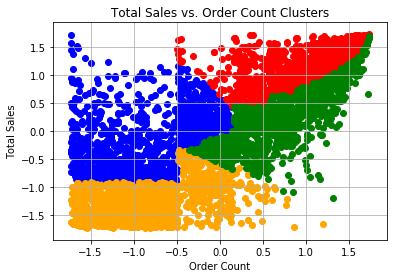

In [52]:
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'],
    c = 'blue')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'],
    c = 'red')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'],
    c = 'orange')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'],
    c = 'green')

plt.title('Total Sales vs. Order Count Clusters')
plt.xlabel('Order Count')
plt.ylabel('Total Sales')

plt.grid()
plt.show()

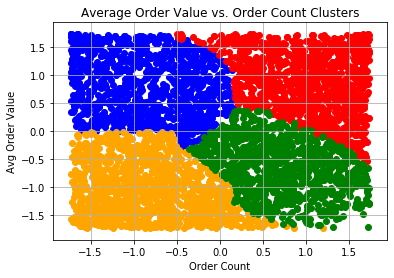

In [53]:
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c = 'blue')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c = 'red')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c = 'orange')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c = 'green')

plt.title('Average Order Value vs. Order Count Clusters')
plt.xlabel('Order Count')
plt.ylabel('Avg Order Value')

plt.grid()
plt.show()

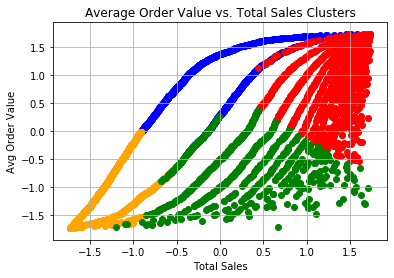

In [54]:
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c = 'blue')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c = 'red')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c = 'orange')
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c = 'green')

plt.title('Average Order Value vs. Total Sales Clusters')
plt.xlabel('Total Sales')
plt.ylabel('Avg Order Value')

plt.grid()
plt.show()

## Determining the Best Number of Clusters
We normally do not know how many clusters to choose. In this case, we began by selecting four clusters. We can use a method of scoring called the **silhouette coefficient** to determine how many clusters to choose. We will run the KMeans algorithm through a loop of cluster values and record the silhouette scores for each cluster. After running the loop, we will print the results and look for the cluster value with the highest score (ranging from 0-1).

In [55]:
from sklearn.metrics import silhouette_score

In [56]:
for n_cluster in [4,5,6,7,8]:
    kmeans = KMeans(n_clusters = n_cluster).fit(
        normalized_df[['TotalSales','OrderCount','AvgOrderValue']]
    )
    silhouette_avg = silhouette_score(
        normalized_df[['TotalSales','OrderCount','AvgOrderValue']],
        kmeans.labels_
    )
    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

Silhouette Score for 4 Clusters: 0.4117
Silhouette Score for 5 Clusters: 0.3782
Silhouette Score for 6 Clusters: 0.3784
Silhouette Score for 7 Clusters: 0.3913
Silhouette Score for 8 Clusters: 0.3809


In this case, we did have the best number of clusters chosen since four clusters had the highest silhouette score of 0.4117.

## Insights from Customer Segments
Now that customers are segmented, what is next? We can analyze the results to determine customer trends and can identify frequently purchased items amongst customers in each segment.

First, we do need to redo our k-means clustering model using four clusters (the loop in the previous section left off with eight clusters so we want to make sure we are using the best model).

In [57]:
kmeans = KMeans(n_clusters = 4).fit(
    normalized_df[['TotalSales','OrderCount','AvgOrderValue']]
    )
four_cluster_df = normalized_df[['TotalSales','OrderCount','AvgOrderValue']].copy(deep = True)
four_cluster_df['Cluster'] = kmeans.labels_

We can look at the cluster centers for each cluster and attribute. We can use the cluster_centers_ code to list out these values in an array but we will go one step further and place these into an easy to read dataframe.

In [72]:
kmeans.cluster_centers_

array([[ 0.24238335,  0.73851656, -0.64070653],
       [-1.23614711, -0.78489856, -1.05740212],
       [ 1.20369724,  0.99722278,  0.87842661],
       [-0.13775005, -0.85149302,  0.79203409]])

In [73]:
clusters_df = pd.DataFrame(data = kmeans.cluster_centers_,
                           index = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3'],
                           columns = ['TotalSales','OrderCount','AvgOrderValue']
                          )
clusters_df

,TotalSales,OrderCount,AvgOrderValue
Cluster 0,0.242383,0.738517,-0.640707
Cluster 1,-1.236147,-0.784899,-1.057402
Cluster 2,1.203697,0.997223,0.878427
Cluster 3,-0.137750,-0.851493,0.792034


The above table gives us the normalized values of the cluster centers. We see that cluster 2 has the highest values for all three attributes - these are the high-value customers who bring in a lot of business. Cluster 1 are low-value customers because they have the lowest values in total sales and average order value. Cluster 3 does have a lower value in order count but it is very close to cluster 1. Cluster 3 has a high average order value though so we can infer that cluster 3 customers have infrequent purchases but they have a great average value though.

We can also assign the cluster values to the original **customer_df** in order to see the actual values instead of the normalized values.

In [71]:
actuals_df = customer_df[['TotalSales','OrderCount','AvgOrderValue']].copy(deep = True)
actuals_df['Cluster'] = kmeans.labels_
actuals_df.head(10)

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,77183.60,1,77183.600000,3
12347.0,4085.18,6,680.863333,2
12348.0,1797.24,4,449.310000,2
12349.0,1757.55,1,1757.550000,3
12350.0,334.40,1,334.400000,3
12352.0,2506.04,8,313.255000,2
12353.0,89.00,1,89.000000,1
12354.0,1079.40,1,1079.400000,3
12355.0,459.40,1,459.400000,3


We can also look at the best selling items for each customer segment. Let's look at cluster 2, our high-value customers.

In [74]:
high_value_cluster = four_cluster_df.loc[four_cluster_df['Cluster'] == 2]

In [75]:
pd.DataFrame(
    df.loc[
        df['CustomerID'].isin(high_value_cluster.index)
    ].groupby('Description').count()[
        'StockCode'
    ].sort_values(ascending = False).head()
)

,StockCode
Description,
JUMBO BAG RED RETROSPOT,1128
REGENCY CAKESTAND 3 TIER,1080
WHITE HANGING HEART T-LIGHT HOLDER,1062
LUNCH BAG RED RETROSPOT,924
PARTY BUNTING,859
